In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
import numpy as np
from face_alignment import FaceAlignment, LandmarksType
from torchvision import transforms
import PIL
import matplotlib.pyplot as plt
import random

from processVoxCelDataset import *

In [2]:
class metaTrainVideoDataset(Dataset):
    def __init__(self, K, rootDir, outputDir, randomFrame, device='gpu', transform=None):
        '''

        :param K:
        :param rootDir: root directory of the video files
        :param outputDir: output directory for generated landmarks
        :param randomSeed: if none
        :param device:
        :param transform:
        '''
        self.K = K
        self.rootDir = rootDir
        self.outputDir = outputDir
        self.randomFrame = randomFrame
        self.device = device
        self.transform = transform

        self.videoList = generateVideoList(rootDir)
        self.fa = FaceAlignment(LandmarksType._2D, device=device)
        self.personNumber = len(os.listdir(rootDir))

    def __len__(self):
        return len(self.videoList)

    def __getitem__(self, idx):
        # get K+1 frames, K for embedder; 1 for generator
        data = generateKSelectedFramesAndLandmarksForSpecificVideo(self.K + 1, self.videoList[idx], self.outputDir,
                                                                   self.fa)
        
        if(self.randomFrame):
            random.shuffle(data)

        data_array = []
        for d in data:
            personId = d["personId"]
            frame = PIL.Image.fromarray(d['frame'], 'RGB')  # [H, W, 3]
            landmarks = PIL.Image.fromarray(d['landmarks'], 'RGB')  # [H, W, 3]
            if self.transform:
                frame = self.transform(frame)  # [3, H, W]
                landmarks = self.transform(landmarks)  # [3, H, W]
            assert torch.is_tensor(frame), "The source images must be converted to Tensors."
            assert torch.is_tensor(landmarks), "The source landmarks must be converted to Tensors."
            data_array.append(torch.stack((frame, landmarks)))  # [2, 3, H, W]
        data_array = torch.stack(data_array)  # [K+1, 2, 3, H, W]
        
        return personId, data_array
#         return idx, data_array


In [3]:
dataset = metaTrainVideoDataset(
    K = 8,
    rootDir = '../../dataForFewShotTalkingHeadModel/train/mp4/',
    outputDir = '../../dataForFewShotTalkingHeadModel/train/output/', 
    randomFrame = True,
    device = 'cpu',
    transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
        ])
    )

dataLoader = DataLoader(dataset, batch_size=2, shuffle=False)

01dfn2spqyE
********
5MkXgwdrmJw
********
7t6lfzvVaTM
********
8_a6O3vdlU0
********
ABlWCST1MPY
********
AXAl9BX9-sQ
********
b5TvWN3x0HA
********
blrmdIfXPwI
********
ddLPBVSzuPs
********
E6aqL_Nc410
********
gjYcaCzo7UU
********
hcr4tT9y3xs
********
iJOjkDq6rW8
********
kN2iEvnTHc4
********
kQJq9nFET5M
********
KtadqxztRBk
********
lvX8diWgriA
********
lZf1RB6l5Gs
********
M6PYYNz3pac
********
MuKhvYeekXU
********
Nd3m-TBtp6A
********
OLguY5ofUrY
********
QLKR38WeXB0
********
SFR_KWObD3o
********
tIpW24N_Ysk
********
U7PMtQkYWo8
********
UGu7qDKCDd8
********
utfjXffHDgg
********
wrB-yyERH2s
********
X9M79aB1RS4
********
yEXiX8Y2qoQ
********
_mjZ87sK6cA
********
0G9G9oyFHI8
********
1P5c4NQjGZY
********
2XrRfyv-EmE
********
46tdg4vE31g
********
4InoPp58-vw
********
4kSyBHethpE
********
7O-tNnnxIDY
********
apa3AUHl8kY
********
bdkqfVtDZVY
********
cAT9aR8oFx0
********
CQMAWovgG_M
********
Df_m1slf_hY
********
DlzVuw1K2qk
********
DM6gU2NY0wg
********
dYDZxcuCWOo
********
F5foYb2Iz2U
*

In [4]:
dataset.personNumber

4

In [5]:
idx, data_array = dataset[0]

In [6]:
idxBatch, landmarkFramesBatch = next(iter(dataLoader))

In [7]:
len(dataLoader)

484

In [12]:
idxBatch

tensor([0, 0])

In [9]:
landmarkFramesBatch.shape

torch.Size([2, 9, 2, 3, 256, 256])

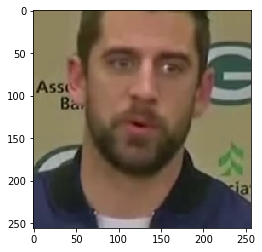

In [11]:
plt.imshow(landmarkFramesBatch[1, 2, 0].permute(1, 2, 0))